# Text classification with movie reviews

This guide classifies movie reviews as positive or negative using the text of reviews.
This is an example of binary classification.

In [16]:
import tensorflow as tf
from tensorflow.python.keras import layers
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

1.13.1


## The IMDB dataset

The IMDB dataset comes packaged with Tensorflow. It has already been preprocessed such that the reviews have been converted 
to sequence to integers.

### Download the dataset

In [2]:
imdb = tf.keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17465344/17464789 [==============================] - 1s 0us/step


### Explore the data

In [3]:
print('Training entries: {}, labels: {}'.format(len(train_data), len(train_labels)))

Training entries: 25000, labels: 25000


Look at the first review, which has been converted to list of integers. Each integer represents a specific word in a dictionary.
Each label is an integer value of either 0 (negative review) or 1 (positive preview).

In [4]:
print('review #0:', train_data[0])
print('label #0:', train_labels[0])

review #0: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
label #0: 1


### Convert the integers back to words

We will create a function to query a dictionary object that contains integer to string mapping.

In [5]:
# a dictionary mapping words to an integer index
word_index = imdb.get_word_index()

# the first indices are reserved
word_index = { k:(v + 3) for k, v in word_index.items() }
word_index['<PAD>'] = 0
word_index['<START>'] = 1
word_index['<UNK>'] = 2     # unknown word
word_index['<UNUSED>'] = 3

reserved_word_index = { v:k for k, v in word_index.items() }

def decode_review(text):
    return ' '.join([reserved_word_index.get(w, '?') for w in text])

1646592/1641221 [==============================] - 0s 0us/step


Display the text of first review.

In [6]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

### Prepare the data

The reviews, the arrays of integers, must be converted to tensors before fed into the neural network.
There can be a couple of ways:
1. Convert the arrays into vectors one-hot encoding. This approach is memory intensive, requiring **num_words x num_reviews**
size matrix. If the number of dictionary is too big, the size of input tensor can be unhandled.
2. We can pad the review arrays having same length, then the memory requires **max_length x num_reviews** size matrix.

This guide will use second approach.

Since, the movie reviews must be the same length, we will use pad_sequences function to standardize the lengths:

In [7]:
train_data = tf.keras.preprocessing.sequence.pad_sequences(train_data, value=word_index['<PAD>'], padding='post', maxlen=256)

test_data = tf.keras.preprocessing.sequence.pad_sequences(test_data, value=word_index['<PAD>'], padding='post', maxlen=256)

Look at the length of reviews now.

In [9]:
len(train_data[0]), len(train_data[1])

(256, 256)

Inspect the first review now.

In [10]:
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

## Build the model
In this guide, the input data consists of an array of word-indices. The labels to predict are either 0 or 1.

In [11]:
# input shape is the vocabulary count usd for the movie reviews (10000 words)
vocab_size = 10000

model = tf.keras.Sequential()
# this layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index.
# these vectors are learned as the model trains, The vectors add a dimension to the output array
# the resulting dimensions are: (batch, sequence, embedding)
model.add(tf.keras.layers.Embedding(vocab_size, 16))
# this layer returns a fixed-length output vector for each example by averaging over the sequence dimension. 
# this allows the model to handle input of variable length, in the simplest way possible.
model.add(tf.keras.layers.GlobalAveragePooling1D())
# the fixed-length output vector is piped through a fully-connected (Dense) layer with 16 hidden units.
model.add(tf.keras.layers.Dense(16, activation=tf.nn.relu))
# the last layer is densely connected with a single output node
model.add(tf.keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


### Learning parameters

A model needs a loss function and an optimizer for training.
Since this is a binary classification problem and the model outputs a probability, we use the binary_crossentropy loss function.

In [12]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

### Create a validation set

When training, we want to check the accuracy of the model on data it hasn't seen before. 
We will create a validation set from the original training data.

In [13]:
# get 10000 validation examples
val_data = train_data[:10000]
train_data = train_data[10000:]

val_labels = train_labels[:10000]
train_labels = train_labels[10000:]

### Train the model

Now, train the model for 40 epochs and mini-batches of 512 samples.

In [14]:
history = model.fit(train_data, train_labels, epochs=40, batch_size=512,
                    validation_data=(val_data, val_labels), verbose=1)

Train on 15000 samples, validate on 10000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/40
15000/15000 [==============================] - 1s 81us/sample - loss: 0.6922 - acc: 0.5622 - val_loss: 0.6907 - val_acc: 0.5949
Epoch 2/40
15000/15000 [==============================] - 1s 56us/sample - loss: 0.6879 - acc: 0.6765 - val_loss: 0.6851 - val_acc: 0.7272
Epoch 3/40
15000/15000 [==============================] - 1s 57us/sample - loss: 0.6791 - acc: 0.7427 - val_loss: 0.6736 - val_acc: 0.7379
Epoch 4/40
15000/15000 [==============================] - 1s 54us/sample - loss: 0.6627 - acc: 0.7555 - val_loss: 0.6536 - val_acc: 0.7429
Epoch 5/40
15000/15000 [==============================] - 1s 56us/sample - loss: 0.6356 - acc: 0.7784 - val_loss: 0.6240 - val_acc: 0.7657
Epoch 6/40
15000/15000 [==============================] - 1s 57us/sample - loss: 0.5988 - acc: 0.7997 - val_loss: 0.5868 - val_acc: 0.7940
Epoch 7/40
15000/15000 [==============================] - 1s 63us/sa

### Graph of accuracy and loss during training

model.fit() returns History object that contains a dictionary with everything that happen during training

In [15]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

We will plot the training and validation loss for comparison, as well as the training and validation accuracy

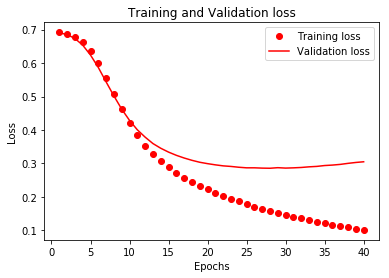

In [17]:
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# 'ro' as 'red dot'
# 'r' as 'solid red line'
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

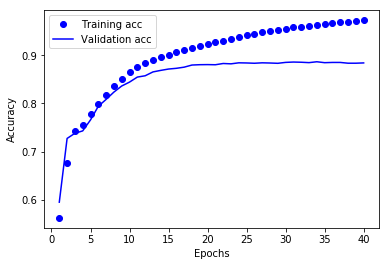

In [18]:
plt.clf() # clear figure

# 'bo' as 'blue dot'
# 'b' as 'solid blue line'
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Notice the training loss decreases with each epoch and the training accuracy increases with each epoch. 
This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy — they seem to peak after about twenty epochs. 
This is an example of over-fitting: the model performs better on the training data than it does on data it has never seen before.

### Evaluate the model

Let's see how the model performs on test dataset.

In [20]:
results = model.evaluate(test_data, test_labels)

print('Loss:', results[0])
print('Acc:', results[1])

25000/25000 [==============================] - 2s 62us/sample - loss: 0.3248 - acc: 0.8735
Loss: 0.32478100824356076
Acc: 0.87348


This fairly naive approach achieves an accuracy of about 87%This fairly naive approach achieves an accuracy of about 87%. With more advanced approaches, the model should get closer to 95%.
